In a previous notebook, I have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

In [6]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [38]:
N = 256 # number of factors (neurones)
n_classes = 10 # number of classes
N_batch = 4 # nb de 
seed = 197 # release year of https://en.wikipedia.org/wiki/Ring_Ring_(ABBA_song)

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix

def psychometric_function(W, factors):
    print(W.shape, factors.shape)
    logit = (factors @ W[:-1, :]) + W[-1, :]
    return 1 / (1 + np.exp(-logit))

def get_data(W, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    factors = np.random.randn(N_batch, N)
    p = psychometric_function(W, factors)
    y = p > np.random.rand(N_batch, n_classes)  # generate data
    
    return factors, p, y

In [41]:
p = psychometric_function(W, factors)
y = p > np.random.rand(N_batch, n_classes)
print(factors, p, y)


(257, 10) torch.Size([4, 256])


TypeError: '>' not supported between instances of 'Tensor' and 'numpy.ndarray'

In [24]:
factors = np.random.randn(N_batch, N)
factors.shape


(4, 256)

In [3]:
factors = np.random.randn(N_batch, N)
factors.shape

(4, 256)

In [ ]:
W.shape

(257, 10)

In [5]:
(factors@W[:-1, :])

array([[  3.72284795,   2.67538781, -14.90896175,  -5.72485107,
         -2.58059732,  18.86628928, -11.32529956,  18.02513564,
         -1.28525839, -18.13646414],
       [-20.36772474, -20.57846068,  -5.20182634, -12.78106246,
         20.31890117,   3.98062632,   9.79560495,  12.17108366,
        -19.10549663,   6.40145308],
       [ -9.26559977,  22.42674373,  -3.24639354, -14.54071906,
         -2.81000287,   5.99615022,  29.06490131,  22.7575556 ,
        -10.19614332,  17.08515671],
       [ 10.38424533,  28.40111101,  -0.96959214,  15.4057801 ,
         14.27348049, -34.73642609,  13.8147869 ,  22.26917954,
         13.08874951,   9.98292308]])

In [6]:
(factors@W[:-1, :]).shape

(4, 10)

In [7]:
((factors@W[:-1, :]) + W[-1, :]).shape

(4, 10)

In [8]:
psychometric_function(W, factors)

(257, 10) (4, 256)


array([[9.69882193e-01, 9.30037732e-01, 5.53236137e-07, 1.03326602e-03,
        5.11181461e-02, 1.00000000e+00, 1.95430934e-06, 9.99999784e-01,
        2.24125883e-01, 1.32350352e-08],
       [1.11043428e-09, 1.05832391e-09, 9.01021809e-03, 8.91634913e-07,
        9.99999998e-01, 9.98574026e-01, 9.99656312e-01, 9.99924687e-01,
        5.26586374e-09, 9.98337085e-01],
       [7.36296090e-05, 1.00000000e+00, 6.03746366e-02, 1.53454007e-07,
        4.10696002e-02, 9.99809753e-01, 1.00000000e+00, 9.99999998e-01,
        3.89704725e-05, 9.99999962e-01],
       [9.99960274e-01, 1.00000000e+00, 3.85063500e-01, 9.99999357e-01,
        9.99999111e-01, 1.07316457e-14, 9.99993823e-01, 9.99999997e-01,
        9.99998020e-01, 9.99953638e-01]])

In [9]:
factors, p, y = get_data(W, seed, N_batch)
factors.shape, p.shape, y.shape

(257, 10) (4, 256)


((4, 256), (4, 10), (4, 10))

(array([10.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0., 25.]),
 array([3.51405419e-17, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

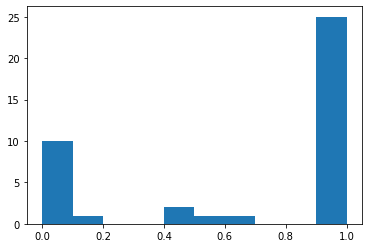

In [10]:
plt.hist(p.ravel(), bins=10)

# inversion

In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, factors):
        return self.nl(self.linear(factors))

In [29]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

In [30]:
logistic_model = LogisticRegressionModel(N, n_classes)

In [31]:
factors = torch.randn(N_batch, N)
outputs = logistic_model(factors)

In [14]:
def fit_data(factors, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = factors.shape[0]
    N = factors.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

In [15]:
factors, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(factors, y, verbose=True)
print("Final loss =", loss)

(257, 10) (10000, 256)
Iteration: 0 - Loss: 0.51191
Iteration: 16 - Loss: 0.11679
Iteration: 32 - Loss: 0.09595
Iteration: 48 - Loss: 0.08673
Iteration: 64 - Loss: 0.08175
Iteration: 80 - Loss: 0.07856
Iteration: 96 - Loss: 0.07641
Iteration: 112 - Loss: 0.07492
Iteration: 128 - Loss: 0.07407
Iteration: 144 - Loss: 0.07360
Iteration: 160 - Loss: 0.07150
Iteration: 176 - Loss: 0.07222
Iteration: 192 - Loss: 0.07206
Iteration: 208 - Loss: 0.07195
Iteration: 224 - Loss: 0.07036
Iteration: 240 - Loss: 0.07067
Iteration: 256 - Loss: 0.07029
Iteration: 272 - Loss: 0.07079
Iteration: 288 - Loss: 0.06933
Iteration: 304 - Loss: 0.07033
Iteration: 320 - Loss: 0.06982
Iteration: 336 - Loss: 0.06929
Iteration: 352 - Loss: 0.06922
Iteration: 368 - Loss: 0.06944
Iteration: 384 - Loss: 0.06908
Iteration: 400 - Loss: 0.07040
Iteration: 416 - Loss: 0.06889
Iteration: 432 - Loss: 0.06974
Iteration: 448 - Loss: 0.06888
Iteration: 464 - Loss: 0.06813
Iteration: 480 - Loss: 0.06891
Iteration: 496 - Loss: 0

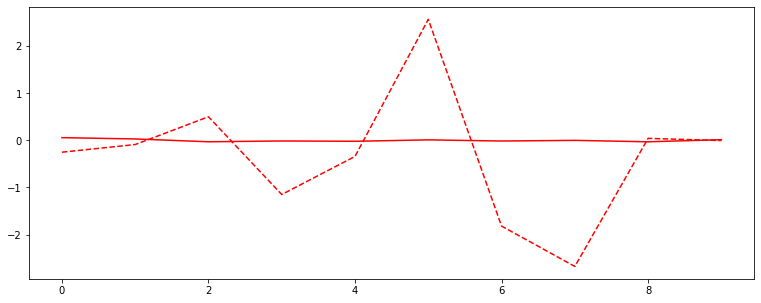

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[-1, :], 'r--')

In [35]:
logistic_model.linear.weight.shape, W.shape

(torch.Size([10, 256]), (257, 10))

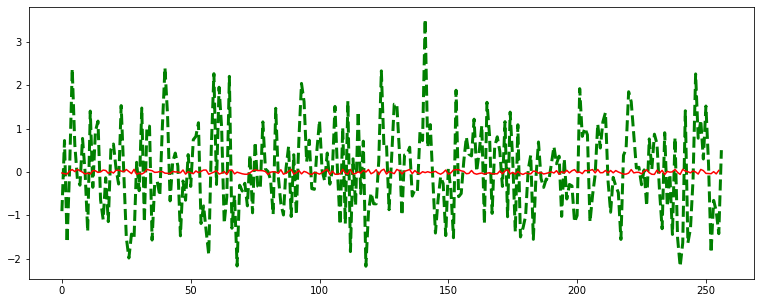

In [36]:
i_digit = 2
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(W[:, i_digit], 'g--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')